We'll download the 2013-2014 data and uncompress it from inside our notebook by invoking the command line (I didn't feel like installing wget on OSX but at least we have curl:

In [ ]:
%%bash
curl https://resources.lendingclub.com/LoanStats3c_securev.csv.zip | tar -xf-

Let's also take a quick look at the data via bash (file size, head, line count, column count).

In [ ]:
!du -h LoanStats3c_securev.csv

In [ ]:
!head -n 2 LoanStats3c_securev.csv

Examining the data we see that most of feature names are intuitive. We can get the specifics from the provided data dictionary at https://www.lendingclub.com/info/download-data.action

In [ ]:
!wc -l < LoanStats3c_securev.csv

In [ ]:
!head -2 LoanStats3c_securev.csv | sed 's/[^,]//g' | wc -c

It looks we have 235,630 entries and 57 attributes. At a glance some of the more notable atributes are:

1. Amount Requested
2. Amount Funded by Investors*
3. Interest Rate
4. Term (Loan Length)
5. Purpose of Loan
6. Debt/Income Ratio **
7. State
8. Rent or Own Home
9. Annual Income
10.  30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
10. FICO Low
11. FICO High
12. Last FICO Low
13. Last FiCO High
12. Credit Lines Open
13. Revolving Balance
14. Inquiries in Last 6 Months
15. Length of Employment

The last vs current FICO scores did not exist the last time we looked at the data, I'm thinking they added this to asses directionality or momentum, although this few of samples is suspicious. Interestingly enough when looking through the attributes provided for declined loans I found a "score" attribute which was desribed as such: 

>*For applications prior to November 5, 2013 the risk score is the borrower's FICO score. For applications after November 5, 2013 the risk score is the borrower's [Vantage](https://en.wikipedia.org/wiki/VantageScore) score.*

I suspect they are actually using both.

*Lending club states that the amount funded by investors has no affect on the final interest rate assigned to a loan.

** Debt/Income Ratio ratio takes all of your monthly liabilities and divides the total by your gross monthly income.

# 1. Our Data
Let's use Pandas to manipulate our data and find an excuse to use the new pipe operators http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pipe.html

Our data is 126mb on disk, 102.2 in memory, not the greatest reduction in side I've seen, but we have a lot of inefficient `object` data types in the df to start.

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline  

In [99]:
df = pd.read_csv("LoanStats3c_securev.csv",skiprows=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235629 entries, 0 to 235628
Data columns (total 56 columns):
id                             235629 non-null int64
member_id                      235629 non-null int64
loan_amnt                      235629 non-null int64
funded_amnt                    235629 non-null int64
funded_amnt_inv                235629 non-null int64
term                           235629 non-null object
int_rate                       235629 non-null object
installment                    235629 non-null float64
grade                          235629 non-null object
sub_grade                      235629 non-null object
emp_title                      222393 non-null object
emp_length                     235629 non-null object
home_ownership                 235629 non-null object
annual_inc                     235629 non-null float64
verification_status            235629 non-null object
issue_d                        235629 non-null object
loan_status                 

In [100]:
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,36805548,39558264,10400,10400,10400,36 months,6.99%,321.08,A,A3,...,0,Jun-2015,321.08,Jul-2015,Jun-2015,679,675,0,59,1
1,38098114,40860827,15000,15000,15000,60 months,12.39%,336.64,C,C1,...,0,Jun-2015,336.64,Jul-2015,Jun-2015,684,680,0,NaN,1
2,37662224,40425321,7650,7650,7650,36 months,13.66%,260.20,C,C3,...,0,May-2015,260.20,Jul-2015,Jun-2015,689,685,0,NaN,1


# Keeping what we need
Let's work through our list of attributes slice-by-slice and figure out what we really need. This involves dropping some useless attributes and cleaning-up/modifying others. Let's work through the columns in batches to keep the cognitive burden low:

In [101]:
# .ix[row slice, column slice] 
df.ix[:4,:7]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate
0,36805548,39558264,10400,10400,10400,36 months,6.99%
1,38098114,40860827,15000,15000,15000,60 months,12.39%
2,37662224,40425321,7650,7650,7650,36 months,13.66%
3,37612354,40375473,12800,12800,12800,60 months,17.14%
4,37822187,40585251,9600,9600,9600,36 months,13.66%


1. We won't need id or member_id as it has no real predictive power so we can drop them from this table
2. int_rate was loaded as an `object` data type instead of `float` due to the '%' character. Let's strip that out and convert the column type.

In [102]:
df.drop(['id','member_id'],1, inplace=True)

In [103]:
df.int_rate = pd.Series(df.int_rate).str.replace('%', '').astype(float)

##  Loan Amount Requested Verus the Funded Amount 
At a glance I thought it important to discover the relationship between loan amount requested verus the funded amount to see if Lending Club ever issues a lower amount than what is asked and **why**. However after taking a look at the data dictionary I discovered that the data has already been manipulated: 

>*"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."*

Alas, it would have been interesting to see how often Lending Club issues a loan that differs from the requested amount. Doing a quick santiy check below we see there are no instances in the data where the reuqested amount doesn't match the funded.

In [104]:
print (df.loan_amnt != df.funded_amnt).value_counts() # Instead of old subset syntax let's use the new `query` method.

# df.query('loan_amnt != funded_amnt').ix[:,:5].head(3) # Old way

False    235629
dtype: int64


Let's keep moving through the columns

In [105]:
df.ix[:5,8:15]

,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status
0,Truck Driver Delivery Personel,8 years,MORTGAGE,58000,not verified,Dec-2014,Current
1,MANAGEMENT,10+ years,RENT,78000,VERIFIED - income source,Dec-2014,Current
2,Technical Specialist,< 1 year,RENT,50000,VERIFIED - income source,Dec-2014,Late (31-120 days)
3,Senior Sales Professional,10+ years,MORTGAGE,125000,VERIFIED - income,Dec-2014,Current
4,Admin Specialist,10+ years,RENT,69000,VERIFIED - income source,Dec-2014,Fully Paid
5,Programming Analysis Supervisor,6 years,RENT,63800,VERIFIED - income source,Dec-2014,Current


## Employment Title
`emp_title` might be a free text field on the application form or a list of currated employment titles. Let's examine how many unique values exist:

In [106]:
print df.emp_title.value_counts().head()
print df.emp_title.value_counts().tail()
df.emp_title.unique().shape

Teacher             4569
Manager             3772
Registered Nurse    1960
RN                  1816
Supervisor          1663
Name: emp_title, dtype: int64
Teacher/Media Specialist          1
teacher/ After School Director    1
bpd/gms coordinator               1
heavy equip operator              1
Corp. Operations Mangager         1
Name: emp_title, dtype: int64


(75353,)

75,353 unique entries among 235,630 observations seems like a bit of a stretch. Taking a look at the head vs tail of the doc shows some suspiciously specific titles such as `bpd/gms coordinator`. I feel comfortable assessing that this data won't be meaningful and any relationship we might observe might be due to confounding relationships. A more advanced implementation might look to group all these job descriptions into categories and/or examine if Lending Club's model looks at (income + job) versus just income, but that's out of the scope of this post.

Here we define a confounding variable as a variable that obscures the effects of another variable. If one 1st grade teacher used a phonics textbook in her class and a different teacher used a whole language textbook in his class, and students in the two classes were
given achievement tests to see how well they read, the independent variables
(teacher effectiveness and textbooks) would be confounded. There is no way to
determine if differences in reading between the two classes were caused by
either or both of the independent variables.

Applying this example to our dataset, Registered Nurses, or RNs, who have higher education requirements and receive above average pay, might be granted A grade loans on average. Is this due to them working as RNs or having a 4-year degree or their salary? Would we see the same effect for Physician Assistants who go to school for longer and receive even more pay? What about Certified Nursing Assistants (CNAs) who are on the oppposite spectrum?

In [107]:
df.drop(['emp_title'],1, inplace=True)

## Employment Length
Leaving this variable in might contradict our decision to drop the employment tile as it also conveyed a sort of socio-economic seniority. A Computer Scientist 5 years into their career would generally have a larger salary than a Kindergarden teacher 10 years into their career. Arguably it might be powerful to combine a grouped, matched, and reduced set of employment titles with their length to create a "purchasing power" metric. Since employment length is an easy scalar, let's leave it in for now. 

We could leave 'emp_length' as categorical data, but it shouldn't be treated as such or as ordinal data since the intervals are easy to determine. We can convert it into numerical data with a simple filter:

In [108]:
df.emp_length.value_counts()

10+ years    79505
2 years      20487
3 years      18267
< 1 year     17982
1 year       14593
4 years      13528
7 years      13099
5 years      13051
n/a          12019
8 years      11853
6 years      11821
9 years       9424
Name: emp_length, dtype: int64

In [109]:
df.replace('n/a', np.nan,inplace=True)
df.emp_length.fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype(int)

## Verification Status
The values of `verification_status` aren't immediately clear. As `VERIFIED - income` and `VERIFIED - income source` could potentially be the same criteria. The provided data dictionary file describes the field as such: _"Indicates if income was verified by LC, not verified, or if the income source was verified"_ This description does not help as you'd intuitively think that you would have to verify the source in order to verify income. For now we'll trust that these are indeed different methods or levels (perhaps even ordinal) of verification.

In [110]:
df.verification_status.value_counts()

VERIFIED - income source    97740
not verified                70661
VERIFIED - income           67228
Name: verification_status, dtype: int64

## Loan Statuses
Moving on to the last column in the slice of the df we are examining: loan status is mutable value that represents the current state of the loan. If anything we might want to examine if all the independent variables and/or interst rate to determine the probability of the loan status at some time. In this post however we are focused on predicting the interest rate granted to an applicant at loan creation. Thus we do not care about this variable and will drop it after examining it out of curiosity.

When examining the distribution among the loan statuses, October has the highest amount of loans right ahead of the holiday season. To clean up the space let's replace the column value with a month only and convert the column back to a string or object type. 

Current               194161
Fully Paid             29346
Charged Off             5488
Late (31-120 days)      3738
In Grace Period         1996
Late (16-30 days)        824
Default                   76
Name: loan_status, dtype: int64


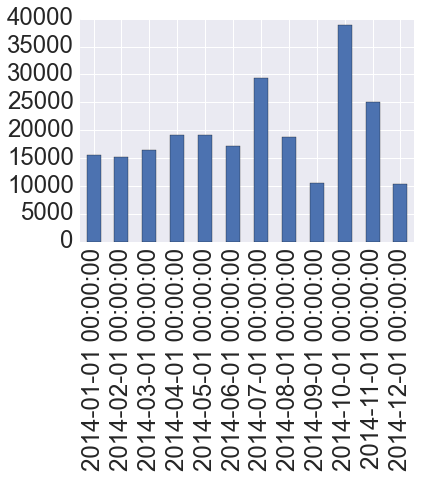

In [111]:
print df.loan_status.value_counts()

issue_d_todate = pd.to_datetime(df.issue_d)# (df['issue_d'].apply(lambda x: x.strftime('%Y-%m-%d')))
df.issue_d = pd.Series(df.issue_d).str.replace('-2014', '')
# We need sort_index() or else we won't get a sequential timedate order.
issue_d_todate.value_counts().sort_index().plot(kind='bar')

df.drop(['loan_status'],1, inplace=True)

## Arbitrary Applicant Input
Continuing on to examine more columns:

In [112]:
df.ix[:5,12:21]

,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti
0,Dec,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,937xx,CA,14.92
1,Dec,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,235xx,VA,12.03
2,Dec,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,850xx,AZ,34.81
3,Dec,n,https://www.lendingclub.com/browse/loanDetail....,NaN,car,Car financing,953xx,CA,8.31
4,Dec,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,077xx,NJ,25.81
5,Dec,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,658xx,MO,18.49


In [113]:
print df.purpose.value_counts()
print ''
print df.title.value_counts().tail()

debt_consolidation    143006
credit_card            55522
home_improvement       13045
other                  10371
major_purchase          3858
medical                 2331
small_business          2277
car                     1832
moving                  1328
vacation                1178
house                    750
renewable_energy         123
wedding                    8
Name: purpose, dtype: int64

consolodate                       1
Chase debt                        1
pay off credit cards and loans    1
Business Consolidation Loan       1
Bills Bills Bills                 1
Name: title, dtype: int64


We'll be dropping `pymnt_plan` as it has the same current state info that `loan_status` had above. It indicates that the loan is in jeopardy and that the borrower has been placed on a payment plan.

Examining the unique counts of purpose show that they are lending club selected options;howver, `title` and `desc` are arbitrary free-text from the applicant.

In [114]:
df.drop(['pymnt_plan','url','desc','title' ],1, inplace=True)

Moving on to examine the next slice of columns:

In [115]:
df.ix[:5,17:25]

,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc
0,0,Sep-1989,710,714,2,42,NaN,17
1,0,Aug-1994,750,754,0,NaN,NaN,6
2,0,Aug-2002,685,689,1,NaN,NaN,11
3,1,Oct-2000,665,669,0,17,NaN,8
4,0,Nov-1992,680,684,0,NaN,NaN,12
5,0,Aug-2003,685,689,0,60,NaN,10


## Delinquency 
Lets examine the distribution of delinquency across all applicants:

In [116]:
df.delinq_2yrs.value_counts()

0     186781
1      31859
2       9831
3       3654
4       1606
5        849
6        426
7        254
8        130
9         84
10        47
12        30
11        28
13        21
14         7
15         5
16         5
18         3
19         3
21         2
17         2
22         2
Name: delinq_2yrs, dtype: int64

## Earliest Credit Line
`earliest_cr_line` is currently an object dtype however we don't want to convert it to a date, rather a scalar to describe the length of time since the first line of credit. We are asserting that if all variables are held equal (number of lines open, income, delinquencies, verfied income); the longer you've had lines of credit the better. 

Conversely an acturary might asses that we can end up with a "u-shaped" distribution in that if you are the extreme end of years, you are a higher risk as you have a higher chance of mortality thus a lower probability of repayment. Additionally pre-retirement debitors are more likely to list job or health reasons as the primary cause of their bankruptcy. 

In a more advanced implementation we'd want to account for confounding variables in that certain applicant groups, the older you are (time since first credit line) the larger your earning potential/power and thus the better loan you might secure, however this increase in salary might be negligible if the amount of discretionary money spent or need for a loan scales in some proportion to the salary size.

In [117]:
from datetime import datetime

df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)

dttoday = datetime.now().strftime('%Y-%m-%d')
# There is a better way to do this :) 
df.earliest_cr_line = df.earliest_cr_line.apply(lambda x: (
        np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

df.earliest_cr_line

0         26
1         21
2         13
3         15
4         23
5         12
6         16
7         17
8         14
9         12
10        14
11         6
12        28
13        12
14        20
15        21
16        19
17        26
18        14
19        17
20         9
21        13
22        14
23         8
24         5
25        10
26        13
27        13
28         8
29        21
          ..
235599    15
235600    14
235601    30
235602    22
235603    30
235604    18
235605    18
235606    22
235607    12
235608    17
235609    22
235610    21
235611    13
235612    13
235613    29
235614    15
235615    21
235616    25
235617    14
235618    32
235619    21
235620    22
235621    17
235622    13
235623    16
235624    12
235625    18
235626    12
235627    13
235628    15
Name: earliest_cr_line, dtype: int64

## FICO Ranges
The FICO `fico_range_low` & `fico_range_high` scores on their own aren't as useful as a range and average. So let's create that. `initial_list_status` is unclear if it describes a post or pre determined interest period. 

In [118]:
df['fico_range'] = df.fico_range_low.astype('str') + '-' + df.fico_range_high.astype('str')
df['meanfico'] = (df.fico_range_low + df.fico_range_high)/2
df.drop(['fico_range_low','fico_range_high','initial_list_status'],1, inplace=True)

Moving on to the next set of columns

In [119]:
df.ix[:5,23:32]

,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp
0,0,6133,31.6%,36,9082.24,9082.24,1595.30,1595.30,1317.76
1,0,138008,29%,17,14072.21,14072.21,1657.39,1657.39,927.79
2,0,16822,91.9%,20,6945.62,6945.62,1026.29,1026.29,704.38
3,0,5753,100.9%,13,12098.99,12098.99,1564.93,1564.93,701.01
4,0,16388,59.4%,44,0.00,0.00,9973.43,9973.43,9600.00
5,0,16374,76.2%,35,20203.61,20203.61,2535.41,2535.41,1221.39


## Revolving Utility
Let's do the same thing we did for the interest rate column

In [120]:
df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

In [121]:
df.ix[:5,23:32]

,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp
0,0,6133,31.6,36,9082.24,9082.24,1595.30,1595.30,1317.76
1,0,138008,29.0,17,14072.21,14072.21,1657.39,1657.39,927.79
2,0,16822,91.9,20,6945.62,6945.62,1026.29,1026.29,704.38
3,0,5753,100.9,13,12098.99,12098.99,1564.93,1564.93,701.01
4,0,16388,59.4,44,0.00,0.00,9973.43,9973.43,9600.00
5,0,16374,76.2,35,20203.61,20203.61,2535.41,2535.41,1221.39


## More Post Loan Attributes
Similar to some attributes we encountered above, we have more columns to drop that detail attributes about the loan after it was granted, which we don't care about.

In [122]:
df.drop(['out_prncp','out_prncp_inv','total_pymnt',
         'total_pymnt_inv','total_rec_prncp', 'grade', 'sub_grade'] ,1, inplace=True)

In [123]:
df.ix[:5,23:32]

,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d
0,31.6,36,277.54,0,0,0,Jun-2015,321.08,Jul-2015
1,29.0,17,729.60,0,0,0,Jun-2015,336.64,Jul-2015
2,91.9,20,321.91,0,0,0,May-2015,260.20,Jul-2015
3,100.9,13,863.92,0,0,0,Jun-2015,319.08,Jul-2015
4,59.4,44,373.43,0,0,0,Apr-2015,9338.58,NaN
5,76.2,35,1314.02,0,0,0,Jun-2015,516.36,Jul-2015


In [124]:
df.drop(['total_rec_int','total_rec_late_fee',
         'recoveries','collection_recovery_fee',
         'collection_recovery_fee' ],1, inplace=True)

In [125]:
df.ix[:5,23:32]

,revol_util,total_acc,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med
0,31.6,36,Jun-2015,321.08,Jul-2015,Jun-2015,679,675,0
1,29.0,17,Jun-2015,336.64,Jul-2015,Jun-2015,684,680,0
2,91.9,20,May-2015,260.20,Jul-2015,Jun-2015,689,685,0
3,100.9,13,Jun-2015,319.08,Jul-2015,Jun-2015,684,680,0
4,59.4,44,Apr-2015,9338.58,NaN,Apr-2015,679,675,0
5,76.2,35,Jun-2015,516.36,Jul-2015,Jun-2015,689,685,0


In [126]:
df.drop(['last_pymnt_d','last_pymnt_amnt',
         'next_pymnt_d','last_credit_pull_d'],1, inplace=True)

In [127]:
df.ix[:5,23:32]

,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,fico_range,meanfico
0,31.6,36,679,675,0,59,1,710-714,712
1,29.0,17,684,680,0,NaN,1,750-754,752
2,91.9,20,689,685,0,NaN,1,685-689,687
3,100.9,13,684,680,0,36,1,665-669,667
4,59.4,44,679,675,0,NaN,1,680-684,682
5,76.2,35,689,685,0,74,1,685-689,687


## Last FICO Ranges
Our previous FICO attributes were the current ranges.

In [128]:
df['last_fico_range'] = df.last_fico_range_low.astype('str') + '-' + df.last_fico_range_high.astype('str')
df['last_meanfico'] = (df.last_fico_range_low + df.last_fico_range_high)/2
df.drop(['last_fico_range_high','last_fico_range_low','policy_code'],1, inplace=True)

## Wrapping Up the Data Munging

Okay so now we got out data down to 61mb from 120mb. Imagine what we could do if we used more efficicent data types! Let's take one last look at it to then move on to our modeling phase.

In [129]:
print df.columns
print df.head(1).values
df.info()

Index([u'loan_amnt', u'funded_amnt', u'funded_amnt_inv', u'term', u'int_rate',
       u'installment', u'emp_length', u'home_ownership', u'annual_inc',
       u'verification_status', u'issue_d', u'purpose', u'zip_code',
       u'addr_state', u'dti', u'delinq_2yrs', u'earliest_cr_line',
       u'inq_last_6mths', u'mths_since_last_delinq', u'mths_since_last_record',
       u'open_acc', u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
       u'collections_12_mths_ex_med', u'mths_since_last_major_derog',
       u'fico_range', u'meanfico', u'last_fico_range', u'last_meanfico'],
      dtype='object')
[[10400 10400 10400 ' 36 months' 6.99 321.08 8 'MORTGAGE' 58000.0
  'not verified' 'Dec' 'credit_card' '937xx' 'CA' 14.92 0 26 2 42.0 nan 17
  0 6133 31.6 36 0 59.0 '710-714' 712.0 '675-679' 677.0]]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 235629 entries, 0 to 235628
Data columns (total 31 columns):
loan_amnt                      235629 non-null int64
funded_amnt                   

In [130]:
df.fillna(0.0,inplace=True)
df.fillna(0,inplace=True)

# 2. Our model
Staying true to the original intent of this blog, reproducing my popular old R post, I will use a gradient boosting regression model (more on this later), even if it's easier to use random forest and avoid dummy encoding of my categorical data. If you walk through the broken out steps above you'll find that we have:

1. Addressed missing data
2. Converted strings to numerical representations where possible
3. Dropped superfluous attributes

**Note:** We have to pay special attention to how we replace missing values since we can introduce bias if the data is not missing at random.

The usual next steps are to:
1. Eliminate zero (or near-zero) variance predictors
2. Highly and correlated predictors

Due to all the categorical variables we might want to use Kendall's correlation matrix. If our data was larger we might want to reduce the size of it via more advanced feature selection methods such as clustering (choosing a single representative of each cluster), PCA, ICA, and so on. Since the purpose of this experiment is explanatory rather than predictive, we wouldn't want to use PCA and try to explain the covariates in terms of principal components.

## Highly Correlated Data
Let's examine our dataframes correlation matrix and drop highly correlated/redundant data to address multicollinearity.

In [131]:
cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

funded_amnt      loan_amnt                 1.000000
funded_amnt_inv  loan_amnt                 0.999997
                 funded_amnt               0.999997
installment      loan_amnt                 0.947978
                 funded_amnt               0.947978
                 funded_amnt_inv           0.947943
pub_rec          mths_since_last_record    0.665077
total_acc        open_acc                  0.684919
dtype: float64

We will drop the non-informative columns found above. Note that we missed a few columns in our munging process above such as `funded_amnt_inv` which is the amount funded by customers at that point in time which is post interest rate determination. We also missed `installment` which is the monthly payment owed by the borrower if the loan originates.

In [132]:
df.drop(['zip_code','funded_amnt','funded_amnt_inv', 'installment', 'mths_since_last_delinq', 'total_acc'], axis=1, inplace=True)

## Feature Space and Labels
Before we go on any further and verify what we already intuitively know. Let's make a quick (wasn't really quick) plot to examine the relationship between interest rate and FICO score. We also can finish this post without replicating the same image from original post from long ago. Arguably it was a lot more intuitive to do in native ggplot back then.

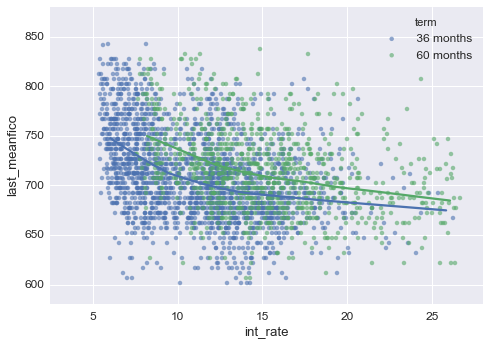

In [138]:
plot_df = df.query('last_meanfico > 600 & int_rate <28')[:3000]

sns.set(font_scale=1.2, rc={"lines.linewidth": 1.5}) 



g = sns.lmplot("int_rate", "last_meanfico", x_jitter= .7,  y_jitter= .1,
           data=plot_df, hue='term',lowess=True, size=5,aspect=1.4, legend_out=False,
           scatter_kws={ 's':20, 'alpha':.6})

g.set(xlim=(2.5, 28),ylim=(580, 880),alpha = .5)

g.savefig('1.png',transparent=True)

In [139]:
y = df.int_rate.values
df.drop('int_rate',axis = 1, inplace=True)

(array([  6.  ,   6.03,   6.49,   6.62,   6.99,   7.12,   7.49,   7.62,
          7.69,   7.9 ,   8.19,   8.39,   8.67,   8.9 ,   9.17,   9.49,
          9.67,  10.15,  10.49,  10.99,  11.44,  11.67,  11.99,  12.39,
         12.49,  12.85,  12.99,  13.35,  13.53,  13.65,  13.66,  13.98,
         14.16,  14.31,  14.47,  14.49,  14.64,  14.98,  14.99,  15.31,
         15.59,  15.61,  15.99,  16.24,  16.29,  16.49,  16.59,  16.99,
         17.14,  17.57,  17.86,  18.24,  18.25,  18.54,  18.92,  18.99,
         19.2 ,  19.22,  19.24,  19.47,  19.52,  19.97,  19.99,  20.2 ,
         20.49,  20.5 ,  20.99,  21.18,  21.48,  21.99,  22.15,  22.4 ,
         22.45,  22.9 ,  22.99,  23.4 ,  23.43,  23.7 ,  23.99,  24.08,
         24.5 ,  24.99,  25.57,  25.8 ,  25.83,  25.89,  25.99,  26.06]),
 <matplotlib.axes._subplots.AxesSubplot at 0x10b435bd0>)

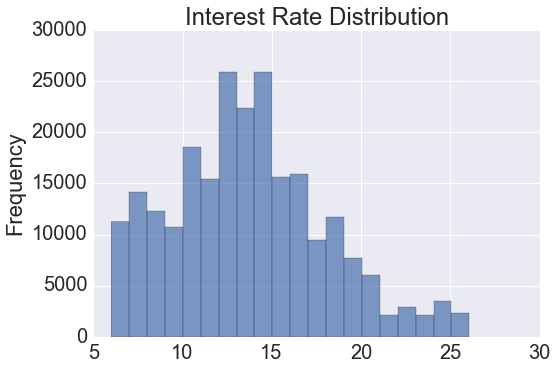

In [38]:
np.unique(y), pd.Series(y).plot(kind='hist',alpha=.7, bins=20, title='Interest Rate Distribution')

We're about to blow up the feature space by dummy-encoding our categorical variables! This will make our dataframe 8x bgger in memory going from 60 to 470MB.

In [39]:
df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235629 entries, 0 to 235628
Columns: 209 entries, loan_amnt to last_fico_range_845-850
dtypes: float64(200), int64(9)
memory usage: 377.5 MB


## Gradient Boosted Regression Trees

Like the original post we will use GBTs. The tradeofs are listed below:

Advantages

- **Heterogeneous data** - Deatures measured on different scale such as employment length vs annual income
- **Supports different loss functions** - We can pick a loss function that suites our problem. If our data contains a lot of missing labels like huber loss, or something specific for ranking problems.
- **Automatically detects (non-linear) feature interactions**,

Disadvantages

- **Requires careful tuning** - RF are faster to tune, they have essentially one parameter
- **Slow to train** - But fast to predict
- **Cannot extrapolate** - It is not possible to predict beyond the minimum and maximum limits of the response variable in the training data.

In [40]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [41]:
X, y = shuffle(df.values, y, random_state=30)
X = X.astype(np.float32)

In [42]:
offset = int(X.shape[0] * 0.75)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

## Training & Tuning
We won't spend too much time in this post tuning, but in general GBTs give us threes knobs we can tune for overfitting: (1) Tree Structure, (2) Shrinkage, (3) Stochastic Gradient Boosting. In the interest of time we'll do a simple grid search amongst a hand chosen set of hyper-parameters.

One of the most effective paramerters to tune for when working with a large feature set is `max_features` as it introduces a notion of randomization similar to Random Forests. Playing with max features allows us to perform subsampling of our feature space before finding the best split node. a `max_features` setting of .20 for example would grow each tree on 20% of the featureset. Conversely the `subsample` feature would use 20% of the training data (all features). Subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.

### Loss Function

- Squared loss minimizes expectation. Pick it when learning expected return on a stock.

- Logistic loss minimizes probability. Pick it when learning probability of click on advertisement.

- Hinge loss minimizes the 0,1 / yes-no question. Pick it when you want a hard prediction.

- Quantile loss minimizes the median. Pick it when you want to predict house prices.

- Ensembling multiple loss functions

Adapted from: https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions

In [ ]:
from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              'max_features': [1.0, 0.3, 0.1]
              }
# param_grid = {'learning_rate': [0.1],
#               'max_depth': [4],
#               'min_samples_leaf': [3],
#               'max_features': [1.0],
#               }

est = GridSearchCV(ensemble.GradientBoostingRegressor(n_estimators=100),
                   param_grid, n_jobs=4, refit=True)

est.fit(X_train, y_train)

best_params = est.best_params_

In [43]:
%%time
est = ensemble.GradientBoostingRegressor(n_estimators=2000).fit(X_train, y_train)

CPU times: user 2h 15min 34s, sys: 5min 43s, total: 2h 21min 18s
Wall time: 3h 28min 36s


In [48]:
est.score(X_test,y_test)

.7644790837986264


## Examing results
In terms of simple model accuracy we know we're doing pretty good with the above score over 3000 iterations gets us in the 90s, 1000 gets us in the 60s.Let's examine how drastically accuracy increased with each iteration and see which model features were most powerful in predicting the issued iterest rate.

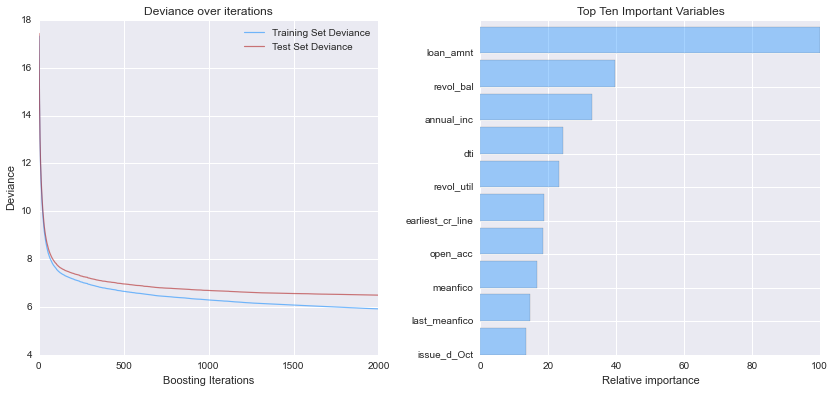

In [54]:
sns.set(font_scale=1, rc={"lines.linewidth":1.2}) 


Iterations = 2000
# compute test set deviance
test_score = np.zeros((Iterations,), dtype=np.float64)

for i, y_pred in enumerate(est.staged_predict(X_test)):
    test_score[i] = est.loss_(y_test, y_pred)

plt.figure(figsize=(14, 6)).subplots_adjust(wspace=.3)

plt.subplot(1, 2, 1)
plt.title('Deviance over iterations')
plt.plot(np.arange(Iterations) + 1, est.train_score_, 'dodgerblue',
         label='Training Set Deviance', alpha=.6)
plt.plot(np.arange(Iterations) + 1, test_score, 'firebrick',
         label='Test Set Deviance', alpha=.6)
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')


plt.subplot(1, 2, 2,)
# Top Ten
feature_importance = est.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

indices = np.argsort(feature_importance)[-10:]
plt.barh(np.arange(10), feature_importance[indices],color='dodgerblue',alpha=.4)
plt.yticks(np.arange(10 + 0.25), np.array(df.columns)[indices])
_ = plt.xlabel('Relative importance'), plt.title('Top Ten Important Variables')

### Partial Dependence Plots
When working with tree models such as GBTs or Random Forests, I like to take a look at Partial Dependence Plots to understand the functional relations between predictors and an outcome. Tese plots capture marginal effect of a given variable or variables on the target function, in this case interest rate.

In the first plot, tt is interesting to note that below $25k annual income, Debt-to-Income ratio has a large effect on the interest rate. The margin gets significantly larger after 75k. The steepness of meanfico is especially interesting, it looks like no real distinction is made for customers with a score over 760.

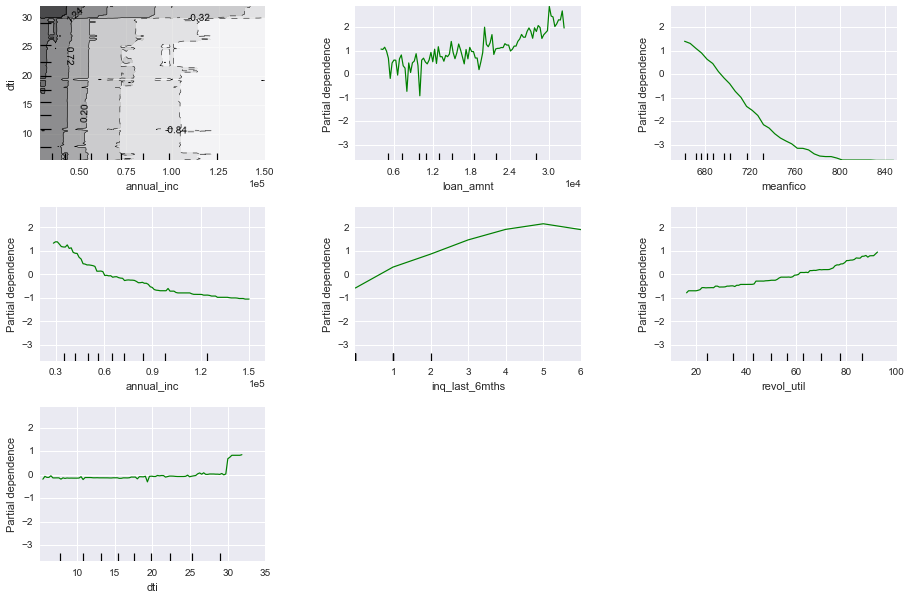

In [55]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

comp_features = [('annual_inc','dti'),'loan_amnt','meanfico','annual_inc', 'inq_last_6mths', 'revol_util', 'dti']

fig, axs = plot_partial_dependence(est, X_train, comp_features,
                                   feature_names=list(df.columns),
                                   figsize=(14, 14), n_jobs=4)

Trying out some alternate plots from `seaborn`.

CPU times: user 2min 3s, sys: 1.14 s, total: 2min 5s
Wall time: 2min 6s


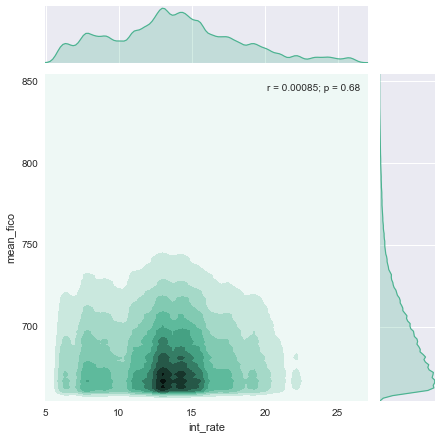

In [56]:
%%time
sns.jointplot(y,df.meanfico.values,annot_kws=dict(stat="r"),
              kind="kde", color="#4CB391").set_axis_labels("int_rate", "mean_fico")